## Imports

In [1]:
# Torch
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# General
import matplotlib
import numpy as np

## Dataset

### Config

In [2]:
CLASSES = 10

### Preparation

In [3]:
# Load dataset
test_set = dsets.MNIST(root='./data', train=False, download=True)
train_set = dsets.MNIST(root='./data', train=True, download=True)

In [4]:
# Data as numpy
test_data = test_set.data.numpy()
train_data = train_set.data.numpy()

# Labels as numpy
test_labels = test_set.targets.numpy()
train_labels = train_set.targets.numpy()

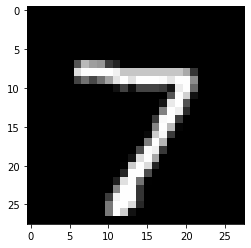

In [5]:
# Plot sample data
import matplotlib.pyplot as plt
%matplotlib inline

img = test_data[0]
plt.imshow(img, cmap='gray')

In [6]:
# Flatten train and test data
test_flattened = test_data.reshape((test_data.shape[0], 784))
train_flattened = train_data.reshape((train_data.shape[0], 784))

print("Test shape (flattened): ", test_flattened.shape)
print("Train shape (flattened): ", train_flattened.shape)

np.array([train_flattened[0, :]]).shape

Test shape (flattened):  (10000, 784)
Train shape (flattened):  (60000, 784)


(1, 784)

In [7]:
# One hot encoding
one_hot_test = np.eye(CLASSES)[test_labels]
one_hot_train = np.eye(CLASSES)[train_labels]

print("Test labels: ", one_hot_test.shape)
print("Train labels: ", one_hot_train.shape)

Test labels:  (10000, 10)
Train labels:  (60000, 10)


## Network

### Config

In [8]:
BATCH = 20
HIDDEN = 15
DEBUG = False
EPSILON = 0.005
EPOCHS = 200 * 3000 # 5 passes over data

### Routines

In [9]:
def mse(y, target,deriv = False):
    if deriv:
        return 2*(target - y)
    return np.sum(np.square(target - y))

# Sigmoid function for the
# activation between input
# and hidden layer, as well
# as hidden to output layer
# activation
def sigmoid(x, deriv=False):
    if(deriv == True):
        return x*(1-x)
    
    return 1/(1+np.exp(-x))

# Softmax activation function
# to normalize the output as
# a vector of probabilities
# for every single possible
# class
def softmax(x, deriv=False):
    if(deriv == True):
        return x*(1-x)

    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    sigma = y / y.sum(axis=1, keepdims=True)
    return sigma

# Feed forward operation
def feed_forward(input_batch, w1, w2):
    # Dot products
    a1 = sigmoid(np.dot(input_batch,w1))
    a1 = np.hstack((a1,np.ones((input_batch.shape[0],1))))
    #print(a1.shape)
    a2 = softmax(np.dot(a1,w2))
    
    return input_batch, a1, a2

# Evaluate learnt weights
def evaluate(test, w1, w2, labels):
    # Metrics
    corrects, wrongs = 0, 0
    
    # Evaluate on test set
    for i in range(len(test)):
        # Add dimension
        data = np.array([test[i]])
        
        # Run feedforward
        _, _, res = feed_forward(data, w1, w2)
        
        # Check result
        res_max = res.argmax()
        if res_max == labels[i]:
            corrects += 1
        else:
            wrongs += 1
            
    return corrects, wrongs

def confusion_matrix(test_data, w1, w2, labels):
        # Confusion matrix
        cm = np.zeros((10, 10), int)
        
        for i in range(len(test_data)):
            # Test sample
            data = np.array([test_data[i]])
            
            # Get result
            _, _, res = feed_forward(data, w1, w2)
            res_max = res.argmax()
            target = labels[i]
            cm[res_max, int(target)] += 1
            
        return cm  

### Training

In [10]:
# Fix random seed
np.random.seed(1)

# Weights
w1 = 2 * np.random.random((784, HIDDEN)) - 1
w2 = 2 * np.random.random((HIDDEN, 10)) - 1
# Biases
b0 = np.zeros((1,HIDDEN))
b1 = np.zeros((1,10))


# Biases with weights 
w1 = np.vstack((w1,b0))
w2 = np.vstack((w2,b1))

for epoch in range(EPOCHS):
    # Index
    idx = epoch % 3000
    
    # Feed forward process
    input_batch = train_flattened[(idx * BATCH):((idx + 1) * BATCH), :]
    input_batch = np.hstack((input_batch,np.ones((20,1))))
    #print(input_batch.shape) 
    a0, a1, a2 = feed_forward(input_batch, w1, w2)
    
    if DEBUG:
        print("A0 shape: ", a0.shape)
        print("A1 shape: ", a1.shape)
        print("A2 shape: ", a2.shape)
    
    # Compute mean error
    y = one_hot_train[(idx * BATCH):((idx + 1) * BATCH), :]
    
    # Print MSE
    if (epoch % 3000) == 0:
        print("MSE: ", mse(a2,y))
    
    if DEBUG:
        print("Error shape: ", error)
        
    # Compute DELTA2
    delta2 = (a2 - y) * softmax(a2, True)
    
    # Compute dw2
    dw2 = np.dot(a1.T, delta2)
    
    
    # Compute DELTA1
    delta1 = np.dot(delta2, w2.T) * sigmoid(a1, True)
    
    dw1 = np.dot(a0.T, delta1[:,0:-1])
    #print("dw2 shape",dw1.shape)
    
    
    if DEBUG:
        print("DELTA2 shape: ", delta2.shape)
        print("dW2 shape: ", dw2.shape)
        print("DELTA1 shape: ", delta1.shape)
        print("dW1 shape: ", dw1.shape)
        
    
    
    # Update weights
    w2 -= (EPSILON * dw2)
    w1 -= (EPSILON * dw1)
    

/Users/youssefshoeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


MSE:  18.69965245733769
MSE:  11.343890197230799
MSE:  8.529086445932426
MSE:  4.398482138513829
MSE:  5.634308462447436
MSE:  4.010166204105497
MSE:  4.6966913289201475
MSE:  4.395888141682924
MSE:  4.431042057369202
MSE:  3.1021032069360794
MSE:  6.430239825952009
MSE:  4.456503185210806
MSE:  2.903455882967537
MSE:  7.217057007965274
MSE:  4.818375282470008
MSE:  4.198406048278394
MSE:  4.415005835413128
MSE:  2.984428235695072
MSE:  2.0789618114976736
MSE:  3.2620134386523976
MSE:  1.9579849755012517
MSE:  2.5552374877556887
MSE:  1.6910366442293085
MSE:  4.128663024602384
MSE:  1.318762979136134
MSE:  1.373553423777511
MSE:  3.3711582595416236
MSE:  0.9377217382182492
MSE:  3.81787134208969
MSE:  3.3690004258410466
MSE:  3.3522688107382
MSE:  1.9429858533566717
MSE:  2.4760246608899017
MSE:  4.031341203232986
MSE:  2.4284425202456354
MSE:  3.912733569671735
MSE:  3.2781428077342305
MSE:  1.791197786700641
MSE:  1.8012783105625627
MSE:  4.575435175495996
MSE:  1.5418849557775764
MS

## Evaluation

### Accuracy

In [11]:
print(test_flattened.shape)
test_flattened = np.hstack((test_flattened,np.ones((10000,1))))
c, w = evaluate(test_flattened, w1, w2, test_labels)

(10000, 784)


/Users/youssefshoeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [12]:
print("The model accuracay is: ", c / (c + w))

The model accuracay is:  0.88


### Confusion Matrix

In [13]:
cm = confusion_matrix(test_flattened, w1, w2, test_labels)

/Users/youssefshoeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [14]:
cm

array([[ 919,    0,   22,    3,    1,   32,   31,    8,    5,   11],
       [   0, 1103,    4,    2,    9,    3,    2,   16,    6,   10],
       [   3,    2,  873,   45,    6,   10,   11,   29,    8,    4],
       [   8,    8,   44,  806,    0,   27,    3,    6,   25,    4],
       [   1,    0,   13,    2,  875,    7,   16,    8,   18,   30],
       [  25,    6,    6,   85,    4,  739,   15,    2,   50,   25],
       [  10,    1,   18,    3,   18,   11,  862,    0,   28,    5],
       [   4,    3,   16,   17,    1,    8,    1,  925,   10,   11],
       [   9,   12,   30,   35,    8,   44,   16,    9,  798,    9],
       [   1,    0,    6,   12,   60,   11,    1,   25,   26,  900]])